In [1]:
import pandas as pd
import torch
import GPUtil
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
fig, axs = plt.subplots(3, sharex=True, figsize=(10,7), dpi=300)
axs[0].plot(timevec[indFR[0]:indFR[1]],orgTMA[indFR[0]:indFR[1]])    # Señal Orginal
axs[0].set_title('Raw Signal',fontweight ="bold", fontsize = 12)

# axs[1].plot(timevec[indFR[0]:indFR[1]],SWTMA[indFR[0]:indFR[1]])  # Senal Slow Wave
# axs[1].set_title('Slow Wave filtering Signal')
axs[1].plot(timevec[indFR[0]:indFR[1]],filtTMA[indFR[0]:indFR[1]])   # Señal band pass 250-500 Hz
axs[1].set_title('Filter Signal (250 - 500 Hz)',fontweight ="bold", fontsize = 12)
# plt.ylim(-0.2,0.2)

contour = axs[2].contourf(timevec[indFR[0]:indFR[1]],frex,mWarr,cmap=cm.CMRmap)
axs[2].set_title('Time - Frequency Spectrum',fontweight ="bold", fontsize = 12)
axs[2]. set_ylim(200, 550)

# -------------------BEGIN-CHANGES------------------------
# Hide the all but the bottom spines (axis lines)
axs[0].spines["right"].set_visible(False)
axs[0].spines["left"].set_visible(False)
axs[0].spines["top"].set_visible(False)

axs[1].spines["right"].set_visible(False)
axs[1].spines["left"].set_visible(False)
axs[1].spines["top"].set_visible(False)

axs[2].spines["right"].set_visible(False)
axs[2].spines["left"].set_visible(False)
axs[2].spines["top"].set_visible(False)

fig.text(0.5, 0.04, 'Time (s)', ha='center', va='center')
fig.text(0.06, 0.5, 'Amplitude (V)', ha='center', va='center', rotation='vertical')
fig.text(0.06, 0.8, 'Amplitude (V)', ha='center', va='center', rotation='vertical')
fig.text(0.06, 0.2, 'Frecuency (Hz)', ha='center', va='center', rotation='vertical')

### Cargar base de datos

In [2]:
## Importar base de datos randomizada dividida en imagenes y etiquetas
X = pd.read_csv(r'D:\onlyImage.csv') 
y = pd.read_csv(r'D:\onlyTarget.csv')
y = y.astype('int64')

In [ ]:
## Imprimir primero datos del DF
# X.head()
# y.head()

In [3]:
# Transformar a numpy array para acceder a los elementos individuales de cada columna
XArr = X['Path'].to_numpy()
yArr = y['Target '].to_numpy()

In [ ]:
# Impresión de vectores
# XArr
# yArr

### Dispositivo de entrenamiento

In [4]:
device = torch.cuda.is_available()

if not device:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
# Tipo de GPU donde se está entrenando la red
gpus = GPUtil.getGPUs()
if gpus:
    for gpu in gpus:
        print(f"ID: {gpu.id}, Name: {gpu.name}, Load: {gpu.load*100}%, Memory Free: {gpu.memoryFree}MB, Memory Used: {gpu.memoryUsed}MB, Memory Total: {gpu.memoryTotal}MB, Temperature: {gpu.temperature} °C")
else:
    print("No GPUs available")

ID: 0, Name: NVIDIA GeForce RTX 4070 Laptop GPU, Load: 25.0%, Memory Free: 7843.0MB, Memory Used: 106.0MB, Memory Total: 8188.0MB, Temperature: 43.0 °C


### Separar en testing, training y validation.
70% Training

15% Testing

15% validation
     

In [81]:
# Dividir en conjunto de entrenamiento y conjunto restante (validación + testing)
# test_size = 0.3  -> 30% del dataset será utilizado para validación y testing 
X_train, X_temp, y_train, y_temp = train_test_split(XArr, yArr, test_size=0.3)

In [ ]:
print(f'Tamaño de entrenamiento X (70%): {X_train.shape[0]}')
print(f'Tamaño de entrenamiento y: {y_train.shape[0]}')
print(f'Tamaño de testing X(30%): {X_temp.shape[0]}')
print(f'Tamaño de testing y: {y_temp.shape[0]}')

In [82]:
# Dividir los datos testing en testing y validación
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [ ]:
print(f'Tamaño de testing X (15%): {X_test.shape[0]}')
print(f'Tamaño de testing y: {y_test.shape[0]}')
print(f'Tamaño de validation X(15%): {X_val.shape[0]}')
print(f'Tamaño de validation y: {y_val.shape[0]}')

## Guardar Datos de entrenamiento y testing 

In [83]:
# Training
df = pd.DataFrame({
                   'Sample': X_train,
                   'Target': y_train     
})

df.to_csv(r'D:\Training.csv',index=False)

In [86]:
# Testing
dfTest = pd.DataFrame({
                   'Sample': X_test,
                   'Target': y_test     
})

dfTest.to_csv(r'D:\TTV\Testing.csv',index=False)


In [87]:
# Validation 
dfVal = pd.DataFrame({
                   'Sample': X_val,
                   'Target': y_val    
})

dfVal.to_csv(r'D:\TTV\Validation.csv',index=False)

### Transformación de imagenes con transpose 

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, targets):
        self.image_paths = image_paths
        self.targets = targets
        self.transforms = transforms.ToTensor()   # Se esta transformando la imagen a un tensor (Normalización individual de la imagen)
        # transforms.ToTensor() normaliza [0-1] los valores de [0-255] (cada imagen individualmente) diviendo cada valor por 255, pasando a valores de punto flotante 
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")  # Cargar la imagen y convertir a RGB
        image = self.transforms(img)
        target = self.targets[idx]                  
        return image, target

## Notas de normalización media y SD


Para X_train la media y la SD por canal son:

media: tensor([0.2486, 0.2486, 0.2486])

SD: tensor([0.2377, 0.2377, 0.2377])

In [5]:
dataset = CustomImageDataset(image_paths=XArr,targets=yArr)

batch = 30
dataloader = DataLoader(dataset=dataset, batch_size=batch,shuffle=True)


In [6]:
def meanSDNormalize(dataloader):
    mean = 0.0
    std = 0.0 
    smp = 0 

    for data in dataloader:      # len(data) = 2 -> Contiene 2 columnas 0: imagenes 1: target 
        batch = data[0]          # batch es un array de [20,256,256,3] -> contiene los datos de las imagenes 
        # Tamaño de muestras 
        batchSam = batch.shape[0] # Num de img en cada muestra (20) # data[0].shape -> [20,256,256,3] 20 imagenesde 256*256 con 3 canale
        smp += batchSam
        # Media y SD para normalización 
        flipbatch = batch.view(batchSam,-1,3) # Flip del la imagen (256*256)-> 65536 -> [20,65536,3]
        mean += flipbatch.mean(1).sum(0)  # se obtiene la media por canal de cada imagen en batch y después se suman todas las medias 
        # # print(mean)                     # Acumulación de las medias
        std += flipbatch.std(1).sum(0)

    mean /= smp
    std /= smp
    
    return(mean,std)

In [7]:
mean,std = meanSDNormalize(dataloader)
  

In [9]:
print(mean)
print(std)


tensor([0.2486, 0.2486, 0.2486])
tensor([0.2377, 0.2377, 0.2377])


In [ ]:
flipbatch.shape
flipbatch.mean(1)

In [ ]:
dataiter = iter(dataloader)
img,lb = next(dataiter)

img.shape

## Esta transformació funcioan

In [ ]:
traingTans = transforms.Compose([ transforms.RandomHorizontalFlip(), # Hace un flip en el sentido horizontal 
                                  transforms.ToTensor(), # toma los valores iniciales y los escala a valores entre 0-1
                                 #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ],
                               ) 

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, targets, transform=None):
        self.image_paths = image_paths
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Cargar la imagen y convertir a RGB
        target = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target
    

In [ ]:
dataset = CustomImageDataset(image_paths=X_train,targets=y_train,transform = traingTans)

In [ ]:
batch = 20
dataloader = DataLoader(dataset=dataset, batch_size=batch,shuffle=True)

In [ ]:
dataiter = iter(dataloader)

In [ ]:
img,lb = next(dataiter)

In [ ]:
img.shape

In [ ]:
def imshow(img):
    # Desnormalizar la imagen
    img = img / 2 + 0.5  # Desnormaliza si has usado Normalization (ejemplo: img / 2 + 0.5)
    npimg = img.numpy()  # Convertir a numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convertir de CxHxW a HxWxC
    plt.show()

In [ ]:
import torchvision
import matplotlib.pyplot as plt 

imshow(torchvision.utils.make_grid(img))

## Aplicar transformación a imagen


In [6]:
import pandas as pd
from PIL import Image
from torchvision import transforms


In [ ]:
trainingData = pd.read_csv(r'D:\TTV\Training.csv')  # Base da datos completa col = 'Sample', 'Target'
X_train = trainingData['Sample']   # Asignar columna de samples a X
y_train = trainingData['Target']   # Asignar columna de target a y 

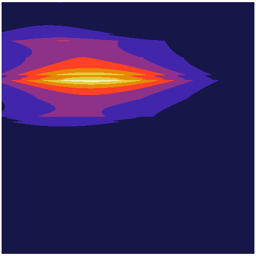

In [12]:
img_path = X_train[1]
image = Image.open(img_path).convert("RGB")
image

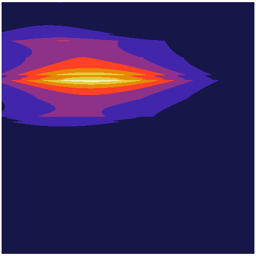

In [43]:
trsHF = transforms.RandomHorizontalFlip(p=.5)
imgHF = trsHF(image)
imgHF

In [ ]:
## Definiendo la transformación de la imagen
tranf = transforms.Compose([ transforms.RandomVerticalFip(),
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ],
                               ) 

In [ ]:
img = Image.open(X_train[0])
img
arr = np.asarray(img)
arr
trs = transforms.ToTensor()
tensor = trs(img)
tensor

### Normalización en na imagen

In [ ]:
from PIL import Image

img = Image.open(X_train[0]).convert('RGB')
img

In [ ]:
transf = transforms.ToTensor()
tenImg = transf(img)

In [ ]:
tenImg.shape

In [ ]:
cnR = tenImg[0,:,:]
print(type(cnR))

In [ ]:
cnG = tenImg[1,:,:]
cnG

In [ ]:
cnB = tenImg[2,:,:]
cnB

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(cnG)

In [ ]:
## Hacer split de la imagen
print(cnR.shape)
splitArr = cnR.view(-1)
print(splitArr.shape)


In [ ]:
splitArr.mean()